In [62]:
import matplotlib
import numpy as np
import os
from numba import njit, prange
import matplotlib.pyplot as plt


step=0.001
v_array = np.arange(0, 0.06,step )
for i in range(len(v_array)):
    v_array[i] = round(v_array[i], 3)

v_dict = {i: v for i, v in enumerate(v_array)}
inverse_v_dict = {v: i for i, v in enumerate(v_array)}

In [63]:


@njit(parallel=True)
def block_designer():
    block_design = np.zeros(3)
    non_zero=np.array([-1, 1])
    all_stim=np.array([-1, 0, 1])
    # stim types is -1 0 or 1
    # we choose first stim randomly between -1 and 1, the rest are completely random among  -1 0 and 1
    block_design[0] = np.random.choice(non_zero)
    block_design[1] = np.random.choice(all_stim)
    if block_design[1] == 0:
        block_design[2] = np.random.choice(non_zero)
    else:
        block_design[2] = np.random.choice(all_stim)

    return np.random.permutation(block_design)


@njit(parallel=True)
def update_velocity(velocity, actual_responces, expected_responces, ANYLOSS=True):
    no_correct = int(np.sum(actual_responces == np.abs(expected_responces)))
    map_dictionary = {0: 0.003, 1: 0.003, 2: -0.002, 3: -0.002}
    
    if ANYLOSS == False:
        map_dictionary = {0: 0.005, 1: 0.005, 2: - 0.005, 3: -0.005}

    return round(velocity + map_dictionary[no_correct], 3)

@njit(parallel=True)
def sigmoid(x,a,b,c,d):
    return (c+ 1/( 1+np.exp((1-x/a)/b) )  )/d

@njit()
def get_sig_parameters(mu,sigma,min_val=0.3333):
    a=mu
    b=sigma
    c=(1/(1+np.exp(1/b))-min_val)/(min_val-1)
    d=c+1
    return a,b,c,d

@njit(parallel=True)
def logistic_responder(mu, sigma, noise, start_velocity, iterations,min_val=0.3333):

    a,b,c,d=get_sig_parameters(mu,sigma,min_val=min_val)    
    probabilties = sigmoid(v_array,a,b,c,d)
    probabilties[0]=noise



    velocities = np.zeros(iterations)
    if probabilties[int(0.04/step)]<0.8  :
        return velocities,-1
    
    velocities[0] = start_velocity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    responses = np.zeros(3)
    v = start_velocity
    zero_one = np.array([0, 1])
    p=0
    for i in range(iterations - 1):
        block = block_designer()
        for j in prange(3):
            prob = probabilties[int(v/step)]
            prob = prob * (1 - noise) + np.random.uniform(0, 1) * (noise)
            p=np.random.uniform(0, 1)
            if p < prob:
                responses[j] = 1
            else:
                responses[j] = 0     
        

        v = update_velocity(velocities[i], responses, block)
        velocities[i + 1] = v
        if v > 0.05 or v < 0.01:
            return velocities, -1
    return velocities, probabilties[int(v/step)]


@njit(parallel=True)
def simulate(mu_spread, sigma_spread, noise_spread, start_velocity, iterations,min_val=0.3333):
    n_agents = mu_spread.shape[0] * sigma_spread.shape[0] * noise_spread.shape[0]
    velocities = np.zeros((n_agents, iterations))
    probabilities = np.zeros(n_agents)

    for i in range(mu_spread.shape[0]):
        if i % 5 == 0:
            print(i/mu_spread.shape[0])
        for j in prange(sigma_spread.shape[0]):
            for k in prange(noise_spread.shape[0]):
                index = i * sigma_spread.shape[0] * noise_spread.shape[0] + j * noise_spread.shape[0] + k
                velocities[index], probabilities[index] = logistic_responder(mu_spread[i], sigma_spread[j],
                                                                             noise_spread[k], start_velocity,
                                                                             iterations,min_val=min_val)

    return velocities, probabilities

In [79]:
mu_spread=np.linspace(0.02,0.04,50)
sigma_spread = np.linspace(0.05,2,50)
intrinsic_noise_spread = np.array([0.01,0.02,0.05,0.1])

iterations = 120
start_velocity = 0.04

velocities, probabilities = simulate(mu_spread, sigma_spread, intrinsic_noise_spread, start_velocity, iterations,min_val=1/3)
converged_indices = np.where(probabilities != -1)[0]
converged_velocities = velocities[converged_indices]
converged_probabilities = probabilities[converged_indices]

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [80]:
converged_muspread = np.zeros(converged_indices.shape[0])
converged_sigmaspread = np.zeros(converged_indices.shape[0])
converged_noisespread = np.zeros(converged_indices.shape[0])
for i  in range(converged_indices.shape[0]):
    converged_muspread[i] = mu_spread[converged_indices[i] // (sigma_spread.shape[0] * intrinsic_noise_spread.shape[0])]
    converged_sigmaspread[i] = sigma_spread[(converged_indices[i] // intrinsic_noise_spread.shape[0]) % sigma_spread.shape[0]]
    converged_noisespread[i] = intrinsic_noise_spread[converged_indices[i] % intrinsic_noise_spread.shape[0]]
print(converged_muspread[0], converged_sigmaspread[0], converged_noisespread[0])


last_20_average=np.mean(converged_velocities[:,-20:],axis=-1)
A,B,C,D=get_sig_parameters(converged_muspread,converged_sigmaspread)
converged_probabilities1=sigmoid(last_20_average,A,B,C,D)




0.02 0.05 0.01


0.5151991295892906


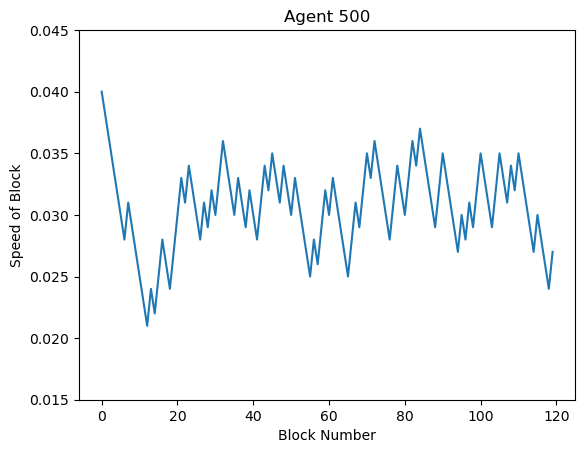

In [76]:
i=500
print(converged_probabilities[i])
plt.plot(converged_velocities[i])
plt.ylabel("Speed of Block")
plt.xlabel("Block Number")
plt.title("Agent "+str(i))
plt.ylim(0.015,0.045)
plt.show()

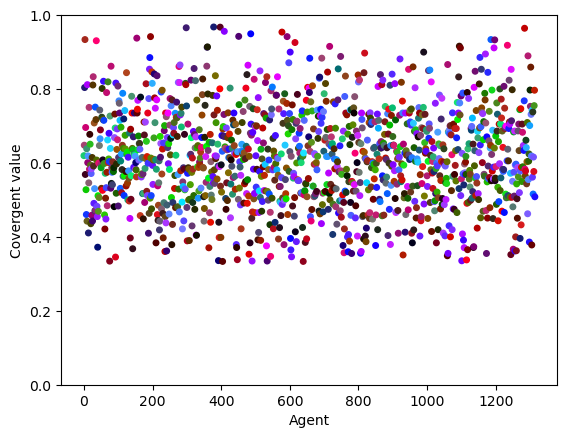

In [81]:

mu_colors=(converged_muspread-converged_muspread.min())/(converged_muspread.max()-converged_muspread.min())
sigma_colors=(converged_sigmaspread-converged_sigmaspread.min())/(converged_sigmaspread.max()-converged_sigmaspread.min())
noise_colors=(converged_noisespread-converged_noisespread.min())/(converged_noisespread.max()-converged_noisespread.min())
colors=np.stack((mu_colors,sigma_colors,noise_colors),axis=1)

order=np.random.permutation(np.arange(len(converged_indices)))
plt.scatter(np.arange(len(converged_indices)),converged_probabilities1[order],16,c=colors[order])
plt.ylim(0,1)

plt.ylabel('Covergent value')
plt.xlabel('Agent')

plt.show()

0.6093607530497426 0.6134198300767403 0.12892326054883527


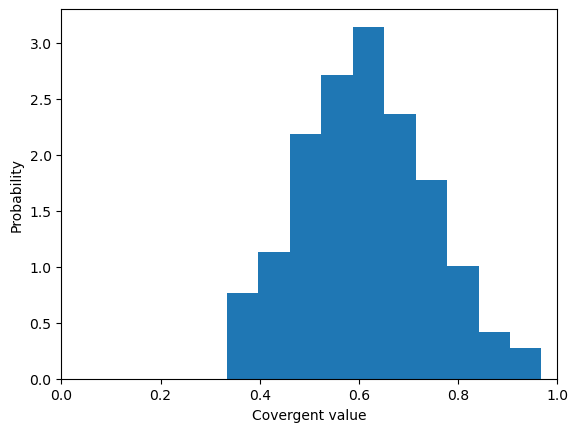

In [82]:
print(np.median(converged_probabilities1),np.mean(converged_probabilities1),np.std(converged_probabilities1))
plt.hist(converged_probabilities1,density=True)
plt.xlim(0,1)
plt.xlabel('Covergent value')
plt.ylabel('Probability')
plt.show()


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.02 0.12959183673469388 0.1


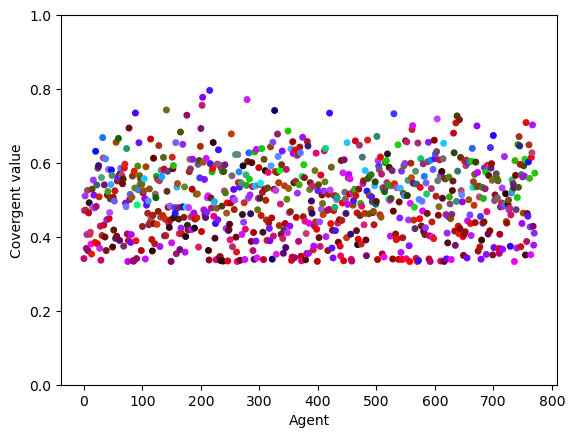

0.5033201363761197 0.5008099849430926 0.09759245878839885


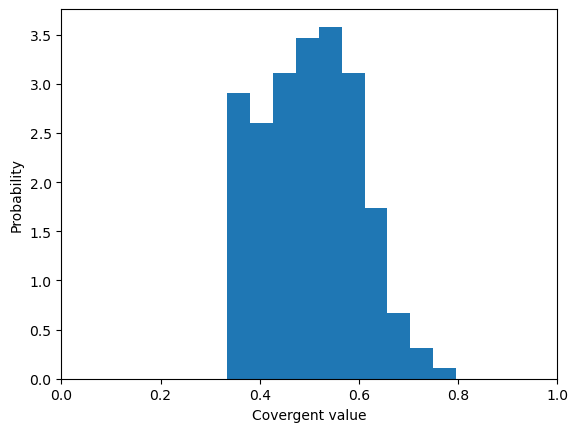

In [69]:
mu_spread=np.linspace(0.02,0.04,50)
sigma_spread = np.linspace(0.05,2,50)
intrinsic_noise_spread = np.array([0.01,0.02,0.05,0.1])

iterations = 120
start_velocity = 0.04

velocities, probabilities = simulate(mu_spread, sigma_spread, intrinsic_noise_spread, start_velocity, iterations,min_val=0.5)
converged_indices = np.where(probabilities != -1)[0]
converged_velocities = velocities[converged_indices]
converged_probabilities = probabilities[converged_indices]
converged_muspread = np.zeros(converged_indices.shape[0])
converged_sigmaspread = np.zeros(converged_indices.shape[0])
converged_noisespread = np.zeros(converged_indices.shape[0])
for i  in range(converged_indices.shape[0]):
    converged_muspread[i] = mu_spread[converged_indices[i] // (sigma_spread.shape[0] * intrinsic_noise_spread.shape[0])]
    converged_sigmaspread[i] = sigma_spread[(converged_indices[i] // intrinsic_noise_spread.shape[0]) % sigma_spread.shape[0]]
    converged_noisespread[i] = intrinsic_noise_spread[converged_indices[i] % intrinsic_noise_spread.shape[0]]
print(converged_muspread[0], converged_sigmaspread[0], converged_noisespread[0])


last_20_average=np.mean(converged_velocities[:,-20:],axis=-1)
A,B,C,D=get_sig_parameters(converged_muspread,converged_sigmaspread)
converged_probabilities1=sigmoid(last_20_average,A,B,C,D)
mu_colors=(converged_muspread-converged_muspread.min())/(converged_muspread.max()-converged_muspread.min())
sigma_colors=(converged_sigmaspread-converged_sigmaspread.min())/(converged_sigmaspread.max()-converged_sigmaspread.min())
noise_colors=(converged_noisespread-converged_noisespread.min())/(converged_noisespread.max()-converged_noisespread.min())
colors=np.stack((mu_colors,sigma_colors,noise_colors),axis=1)

order=np.random.permutation(np.arange(len(converged_indices)))
plt.scatter(np.arange(len(converged_indices)),converged_probabilities1[order],16,c=colors[order])
plt.ylim(0,1)

plt.ylabel('Covergent value')
plt.xlabel('Agent')
plt.show()
print(np.median(converged_probabilities1),np.mean(converged_probabilities1),np.std(converged_probabilities1))
plt.hist(converged_probabilities1,density=True)
plt.xlim(0,1)
plt.xlabel('Covergent value')
plt.ylabel('Probability')
plt.show()